In [1]:
%pylab inline
#%matplotlib notebook
import xarray as xr
from glob import glob
from scipy import stats
import pandas as pd
#from xradd import *
from rrtmg_lw_functions import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from string import ascii_lowercase
from scipy.interpolate import griddata
from netCDF4 import Dataset
from scipy import interpolate
import time
from datetime import datetime
import calendar
from datetime import timedelta 
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


## Description

This notebook shows the comparison of delta T vs delta H2O distribution in GEM and in ER-2 in situ measurements. I also stored the dataset of delta T vs delta H2O distribution from GEM for future use.

In [2]:
def sat_mix_mk(p,t):
    idx1 = np.where(t>273.5)
    if t>273.5:

        esi = np.exp(54.842763-6763.22/t-4.210*np.log(t) +\
        0.000367*t+np.tanh(0.0415*(t-218.8))*(53.878-1331.22/t - \
        9.44523*np.log(t)+0.014025*t))/ 100. # hPa
    if t<=273.5:

        esi = np.exp(9.550426-5723.265/t+3.53068*np.log(t)-0.00728332*t)/100.0 # hPa
    h2o=esi/(p-esi) # the mixing ratio
    if esi*100>p:
        h2o=esi/p
    if h2o>=1:
        h2o = np.nan
    return h2o*1e6

### 1. Get ER-2 data

##### First read ER-2 water vapor

Includes: Start_UTC, H2O(v)_ppmv

In [3]:
indir1 = '/storage/xwang/transfer_data/data/er-2/'
f1 = open(indir1+'SEAC4RS-JLH_ER2_20130827_R1.ict','r') 
top_line=34
for i in range(top_line):
    line=f1.readline()
data_all = f1.readlines()
ndata = np.shape(data_all)[0]

dt = data_all
dt = ''.join(dt).replace('\n',' ')
dt = ''.join(dt).replace(',',' ')
dt = " ".join(dt.split())
dt = dt.split(' ')
dt = np.array([float(i) for i in dt])
dt = np.reshape(dt,(ndata,2)).T
dt[dt==-9999]=np.nan
er_wv = dt*1.

##### Next read ER-2 pressure and temperature

Includes: TIME_UTC, P, T

In [4]:
indir1 = '/storage/xwang/transfer_data/data/er-2/'
f1 = open(indir1+'SEAC4RS-MMS-1HZ_ER2_20130827_R0.ict','r') 
top_line=50
for i in range(top_line):
    line=f1.readline()
data_all = f1.readlines()
ndata = np.shape(data_all)[0]

dt = data_all
dt = ''.join(dt).replace('\n',' ')
dt = ''.join(dt).replace(',',' ')
dt = " ".join(dt.split())
dt = dt.split(' ')
dt = np.array([float(i) for i in dt])
dt = np.reshape(dt,(ndata,16)).T
dt[dt<=-9999]=np.nan
er_pt = dt[:3,:]/100.
er_pt[0,:]*=100

##### Read ER-2 x,w,z

Includes: Start_UTC,Latitude,Longitude,GPS_Altitude

In [5]:
indir1 = '/storage/xwang/transfer_data/data/er-2/'
f1 = open(indir1+'seac4rs-nasdat_er2_20130827_r0.ict','r') 
top_line=54
for i in range(top_line):
    line=f1.readline()
data_all = f1.readlines()
ndata = np.shape(data_all)[0]

dt = data_all
dt = ''.join(dt).replace('\n',' ')
dt = ''.join(dt).replace(',',' ')
dt = " ".join(dt.split())
dt = dt.split(' ')
dt = np.array([float(i) for i in dt])
dt = np.reshape(dt,(ndata,22)).T
dt[dt<=-9999]=np.nan
er_xyz = dt[:4,:]


##### Make sure the three datasets are on the same time steps

In [6]:
er_idx1=np.array([],dtype='int')
er_idx2=np.array([],dtype='int')
er_idx3=np.array([],dtype='int')
for i in range(25888):
    if er_xyz[0,i]>=er_wv[0,:].min() and er_xyz[0,i]<=er_wv[0,:].max():
        er_idx1 = np.append(er_idx1,np.where(er_wv[0,:]==round(er_xyz[0,i],0))[0][0])
        er_idx2 = np.append(er_idx2,np.where(abs(er_pt[0,:]-round(er_xyz[0,i],0))<=1)[0][0])
        er_idx3 = np.append(er_idx3,i)
er_wv = er_wv[:,er_idx1]*1.
er_pt = er_pt[:,er_idx2]*1.
er_xyz = er_xyz[:,er_idx3]*1.

##### make a list of timeseries

In [7]:
starttime=datetime(year=2013,month=8,day=27)
ntime = np.size(er_xyz[0,:])
timeseries = ['']*ntime
for i in range(ntime):
    tmp = timedelta(seconds=er_xyz[0,i]) +starttime
    timeseries[i] = str(tmp.year)+'-'+str(tmp.month).zfill(2)+'-'+str(tmp.day).zfill(2)+' '+\
    str(tmp.hour).zfill(2)+':'+str(tmp.minute).zfill(2)+':'+str(tmp.second).zfill(2)

In [8]:
timeseries[0],timeseries[-1]

('2013-08-27 17:08:47', '2013-08-27 23:49:26')

##### Show the flight track. Red is marked as pressure levels 95~105 hPa

For more ER-2 data plots and analyses, refer to Zhipeng's paper (https://doi.org/10.5194/acp-20-2143-2020) and Smith et al. 2017 (https://doi.org/10.1002/2017JD026831).

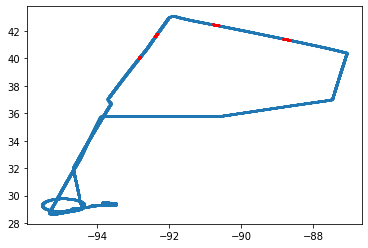

In [9]:
plt.scatter(er_xyz[2,:],er_xyz[1,:],s=1)
idx_lat = np.where(er_xyz[1,:]>=40)[0]                                          # select latitude > 40N
idx_p = np.where(np.logical_and(er_pt[1,idx_lat]<=105,er_pt[1,idx_lat]>=95))[0] # select pressure levels 95~105 hPa
plt.scatter(er_xyz[2,idx_lat[idx_p]],er_xyz[1,idx_lat[idx_p]],s=1,color='r')

### 2. Get MLS data for background mean value

In [10]:
indirm = '/storage/xwang/transfer_data/data/MLS/'
fm = xr.open_dataset(indirm+'MLS-Aura_L2GP_v04_H2O_2010-2015JJA.nc')
fm2 = xr.open_dataset(indirm+'MLS-Aura_L2GP_v04_Temperature_2010-2015JJA.nc')

In [11]:
latm = fm.lat.data
lonm = fm.lon.data
h2om = fm.H2O.data*1e6 ## convert to ppmv
prm = fm.pressure.data
time1 = fm.time.data

In [12]:
latm2 = fm2.lat.data
lonm2 = fm2.lon.data
ttm = fm2.Temperature.data
prm2 = fm2.pressure.data
time2=fm2.time.data

##### Make sure the T and H2O are on the same time steps

In [13]:
ntimem = min(len(time1),len(time2))
idx1 = np.array([],dtype='int')
for i in range(ntimem):
    if time2[i] in time1:
        iii = np.where(time1==time2[i])[0][0]
        idx1 = np.append(idx1,iii)
        
latm=latm[idx1]
lonm=lonm[idx1]
h2om=h2om[idx1]
time1=time1[idx1]

In [14]:
latm[latm==0]=np.nan # Convert zero values to NAN, so that when computing weighted average, there won't be weights=0
latm2[latm2==0]=np.nan

##### Select data: 2013/08, latitude between 38-45 N

In [15]:
iaug = np.where(np.logical_and(time1>=2013.08,time1<=2013.09))[0]
iloc1 = np.where(np.logical_and(latm[iaug,:]>=38,latm[iaug,:]<=45))
iloc2 = np.where(np.logical_and(latm2[iaug,:]>=38,latm2[iaug,:]<=45))

##### use weighted average for the background mean

In [16]:
wgt1=np.cos(np.deg2rad(latm))[:,:,np.newaxis]
h2omm = (np.nansum((h2om*wgt1)[iaug,:][iloc1[0],iloc1[1],12])/np.nansum(wgt1[iaug,:][iloc1[0],iloc1[1],:]))
wgt2=np.cos(np.deg2rad(latm2))[:,:,np.newaxis]
ttmm = (np.nansum((ttm*wgt1)[iaug,:][iloc2[0],iloc2[1],12])/np.nansum(wgt2[iaug,:][iloc2[0],iloc2[1],:]))
print('mean H2O:',h2omm,'ppmv')
print('mean T:',ttmm,'K')

mean H2O: 4.9699087 ppmv
mean T: 204.48657 K


#### I suggest using MLS as the background mean value

Other options I ried:

Refer to all ER-2 flights in August in 2_2_ER-2_data_all_august.ipynb. The ER-2 flight tracks are mostly through active convection, so their data is not the ideal for "background" mean value.

For ERA5 August data at 100 hPa around this latitude range, the mean water vapor is 5.63 ppmv, and T is 210.7 K, which is higher than the MLS value. Double check ERA5 data if necessary.

### 3. Get GEM data. Show the GEM T vs water vapor distribution

#### First get the data at 0001 min, the beginning of the model run (before convection), to compute the background mean for GEM

In [17]:
indir = '/storage/xwang/transfer_data/data/GEM_1p0_griddata/'
ffw0=xr.open_dataset(indir+'2013082512_0001m_1p0_h2o_mix_gz.nc')
ff0=xr.open_dataset(indir+'2013082512_0001m_1p0_tt_theta_thetav_gz.nc')
lat1 = 40;lat2=52
wv0=ffw0.h2o_mix.sel(lat=slice(lat1,lat2)).data
tt0=ff0.tt.sel(lat=slice(lat1,lat2)).data
alt = ff0.level.data

#lat1 = 45;lat2=52
lat = ff0.lat.sel(lat=slice(lat1,lat2)).data
lon=ff0.lon.data
nlat = np.size(lat)
nlon=np.size(lon)

iilev1 = 32 
iilev2 =37
print(alt[iilev1:iilev2+1],'km')
wvm0 = np.nanmean(wv0[iilev1:iilev2,:],axis=-1)
wvstd0 = np.nanstd(wv0[iilev1:iilev2,:],axis=-1)
ttm0 = np.nanmean(tt0[iilev1:iilev2,:],axis=-1)

[16.25 16.5  16.75 17.   17.25 17.5 ] km


##### Read data at 600 min

In [18]:
ttstr = '600'
ff=xr.open_dataset(indir+'2013082512_0'+ttstr+'m_1p0_tt_theta_thetav_gz.nc')
ffw=xr.open_dataset(indir+'2013082512_0'+ttstr+'m_1p0_h2o_mix_gz.nc')
ffp=xr.open_dataset(indir+'2013082512_0'+ttstr+'m_1p0_P_rhou_gz.nc')


nnlev=iilev2-iilev1
wv = ffw.h2o_mix.sel(lat=slice(lat1,lat2)).isel(level=slice(iilev1,iilev2)).data
tt=ff.tt.sel(lat=slice(lat1,lat2)).isel(level=slice(iilev1,iilev2)).data


wv_anom = wv-wvm0[:,:,np.newaxis]
wv_anom2 = wv-wvm0[:,:,np.newaxis]-wvstd0[:,:,np.newaxis]
wv_anom3 = wv-wvm0[:,:,np.newaxis]-3*wvstd0[:,:,np.newaxis]
tt_anom = tt-ttm0[:,:,np.newaxis]


#### Get the wv_anom vs t_anom distribution map

In [19]:
wvbin = np.arange(-10,51,1) # water vapor anomaly bin
ttbin = np.arange(-20,21,1) # temperature anomaly bin
nwvbin = np.size(wvbin)-1
nttbin = np.size(ttbin)-1

twmoist = np.zeros((nwvbin,nttbin))
twelse = np.zeros((nwvbin,nttbin))


for ilev in range(nnlev):
    idxtw = np.where(wv_anom3[ilev,:]>0) # only choose locations where wv_anom3>0
    npoint = np.size(idxtw[0])
        
    for j in range(npoint):
        idx11 = np.where(wvbin>=wv_anom[ilev,idxtw[0][j],idxtw[1][j]])[0]
        idx22 = np.where(ttbin>=tt_anom[ilev,idxtw[0][j],idxtw[1][j]])[0]
        if len(idx11)>0 and len(idx22)>0: 
            idxwv = idx11[0]-1
            idxtt = idx22[0]-1 
            twmoist[idxwv,idxtt]+=1
            
 
    
    idx2 = np.where(wv_anom[ilev,:]<=0)
    npoint2 = np.size(idx2[0])
    for j in range(npoint2):
        idx33 = np.where(wvbin>=wv_anom[ilev,idx2[0][j],idx2[1][j]])[0]
        idx44 = np.where(ttbin>=tt_anom[ilev,idx2[0][j],idx2[1][j]])[0]
        if len(idx33)>0 and len(idx44)>0:
            idx22 = idx33[0]-1
            idx33 = idx44[0]-1 
            twelse[idx22,idx33]+=1
                

##### Plot the distribution. Make sure the computation is OK

Add a tt_anom vs wv_anom curve based on Clausius Clapeyron at 100 hPa

In [20]:
t_cc = np.arange(-20,5,1)
sat_cc = np.zeros_like(t_cc)
ttm0 = np.nanmean(tt0[iilev1:iilev2,:])
wvm0 = np.nanmean(wv0[iilev1:iilev2,:])
for i in range(len(t_cc)):
    sat_cc[i] = sat_mix_mk(100,t_cc[i]+ttm0)-wvm0

In [21]:
ttx = (ttbin[1:]+ttbin[:-1])/2.
wvy = (wvbin[1:]+wvbin[:-1])/2.

(-10.0, 50.0)

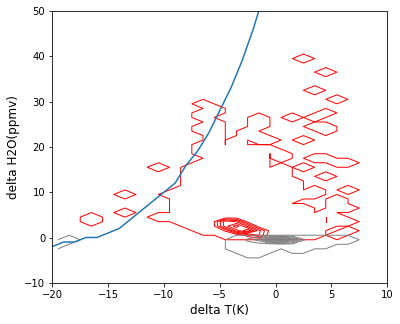

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(6,5, forward=True)

ax.plot(t_cc,sat_cc)
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1)
ax.contour(ttx,wvy,twelse,colors='grey',linewidths=1)

ax.set_xlabel('delta T(K)',fontsize=12)
ax.set_ylabel('delta H2O(ppmv)',fontsize=12)

ax.set_xlim([-20,10])
ax.set_ylim([-10,50])


### linear fit of 90% GEM data

Select the most dense 90% population

In [23]:
level2 = np.sort(twmoist.flatten())[::-1][11]
idx1 = np.where(twmoist>=level2)
print(round(twmoist[idx1[0],idx1[1]].sum()/twmoist.sum()*100,2),'%')
n90 = int(twmoist[idx1[0],idx1[1]].sum())
print(n90,'grid points')
nidx1 = np.shape(idx1)[1]

88.9 %
448918 grid points


In [24]:
wvr = np.zeros(n90)
ttr = np.zeros(n90)
kk = 0
for ilev in range(nnlev):
    idxtw = np.where(wv_anom3[ilev,:]>0)
    npoint = np.size(idxtw[0])
    for j in range(npoint):
        idx11 = np.where(wvbin>=wv_anom[ilev,idxtw[0][j],idxtw[1][j]])[0]
        idx22 = np.where(ttbin>=tt_anom[ilev,idxtw[0][j],idxtw[1][j]])[0]
        if len(idx11)>0 and len(idx22)>0: 
            idxwv = idx11[0]-1
            idxtt = idx22[0]-1
            for iii in range(nidx1):
                if idxwv == idx1[0][iii] and idxtt == idx1[1][iii]:
                    wvr[kk]=wv_anom[ilev,idxtw[0][j],idxtw[1][j]]*1.
                    ttr[kk]=tt_anom[ilev,idxtw[0][j],idxtw[1][j]]*1.
                    kk+=1
          

<ipython-input-25-f3941fcb94dd>:7: UserWarning: No contour levels were found within the data range.
  ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1,levels=[level1])


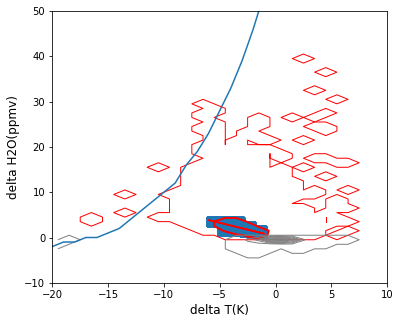

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(6,5, forward=True)

level1 = np.sort(twmoist.flatten())[::-1][-1]

ax.plot(t_cc,sat_cc)
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1,levels=[level1])
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=2,levels=[level2])
ax.contour(ttx,wvy,twelse,colors='grey',linewidths=1)

ax.set_xlabel('delta T(K)',fontsize=12)
ax.set_ylabel('delta H2O(ppmv)',fontsize=12)

ax.set_xlim([-20,10])
ax.set_ylim([-10,50])

### compute the linear fit
ax.scatter(ttr,wvr,color='tab:blue')
slp = np.polyfit(ttr,wvr,1)
ax.plot(ttr,ttr*slp[0]+slp[1],color='r')

### 4. Compare GEM data with ER-2 data

Blue dots are ER-2 data

<ipython-input-26-1ad99f358c53>:7: UserWarning: No contour levels were found within the data range.
  ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1,levels=[level1])


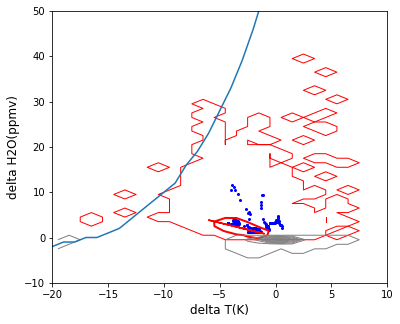

In [26]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(6,5, forward=True)

level1 = np.sort(twmoist.flatten())[::-1][-1]

ax.plot(t_cc,sat_cc)
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1,levels=[level1])
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=2,levels=[level2])

ax.contour(ttx,wvy,twelse,colors='grey',linewidths=1)

ax.set_xlabel('delta T(K)',fontsize=12)
ax.set_ylabel('delta H2O(ppmv)',fontsize=12)

ax.set_xlim([-20,10])
ax.set_ylim([-10,50])

### the linear fit
ax.plot(ttr,ttr*slp[0]+slp[1],color='r')

### The ER-2 data
ax.scatter(er_pt[2,idx_lat[idx_p]]-ttmm,er_wv[1,idx_lat[idx_p]]-h2omm,color='b',s=4)

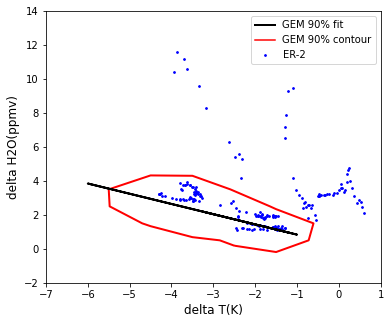

In [27]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(6,5, forward=True)
ax.plot(ttr,ttr*slp[0]+slp[1],color='k',linewidth=2,label='GEM 90% fit')
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=2,levels=[level2])
ax.plot(0,0,color='r',label='GEM 90% contour')

ax.scatter(er_pt[2,idx_lat[idx_p]]-ttmm,er_wv[1,idx_lat[idx_p]]-h2omm,color='b',s=3,label='ER-2')

ax.set_xlabel('delta T(K)',fontsize=12)
ax.set_ylabel('delta H2O(ppmv)',fontsize=12)


ax.set_xlim([-7,1])
ax.set_ylim([-2,14])
ax.legend()
#plt.plot(xx,yy)
#plt.scatter(xx[idxnum[idxs]],yy2[idxnum[idxs]],color='r',s=3)

## Conclusion

The ER-2 data is a measurement of an overworld water vapor plume long after the convection is gone (Smith et al. 2017 https://doi.org/10.1002/2017JD026831).

The GEM data at 100hPa is also showing an overworld water vapor plume at the similar region.

The ER-2 delta_T vs delta_wv fall within the GEM 90% distribution. This means the model has good agreement with the ER-2 observation. The 90% GEM delta_T vs delta_wv can be a good representation of the relationship between the two cariables

### 5. Save some data for futrue use

##### Only run the codes below if you need to regenerate new dataset. 

I have already generated and saved the datasets. Run the codes below if you need to enerate a new set of data (e.g. perturb other layers, GEM data at other time steps, etc.).


#### Save the GEM T-wv distribution for future use

I have already stored the dataset.

Only run it if you need to generate new data.

In [1]:
# datas = xr.Dataset({'twmoist':(['delta_wv','delta_t'],twmoist),'twelse':(['delta_wv','delta_t'],twelse),\
#                    't90':(['npoints'],ttr),'wv90':(['npoints'],wvr)},\
# coords={'delta_wv':(['delta_wv'],wvy),'delta_t':(['delta_t'],ttx),'npoints':(['npoints'],np.arange(len(ttr)))})
# outdir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
# datas.to_netcdf(path=outdir+'GEM_'+ttstr+'m_1p0_100hPa_deltaT_deltaH2O_distribution.nc',mode='w',format='NETCDF4')           

#### Use the GEM T-wv distribution to generate perturb data for rrtmg



In [28]:
idx_data = np.where(twmoist>0)
nset = np.shape(idx_data[1])[0]
wv_t_anom_set = np.zeros((2,nset))
for i in range(nset):
    wv_t_anom_set[0,i] = wvbin[idx_data[0][i]]
    wv_t_anom_set[1,i] = ttbin[idx_data[1][i]]

#### Add the deltaT and deltaH2O to the idealized background profiles

For the example analysis, only add anomalies to 100 hPa

In [29]:
indir2 = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
ff0 = xr.open_dataset(indir2+'idealized_gem_profiles_p_t_wv_perturb_base_radius_center_egde.nc')
p_ave = ff0.P_ave.data[0,0,:]
p_lev = ff0.P_lev.data[0,0,:]
gas_mr_wv = ff0.gas_mr_wv.data*1e6 # convert to ppmv
gas_mr_o3 = ff0.gas_mr_o3.data
T_ave = ff0.T_ave.data
T_lev = ff0.T_lev.data
ff0.close()

In [30]:
ilev = 54
print('Perturbation layer: ',p_lev[54],'hPa')
wvp = np.ones((3,nset+1,77))*gas_mr_wv[:,0,:][:,np.newaxis,:]
ttp = np.ones((3,nset+1,77))*T_ave[:,0,:][:,np.newaxis,:]   ## perturb layer average
ttlup = np.ones((3,nset+1,78))*T_lev[:,0,:][:,np.newaxis,:] ## perturb upper boundary
ttldp = np.ones((3,nset+1,78))*T_lev[:,0,:][:,np.newaxis,:] ## perturb lower boundary

for i in range(1,nset+1):
    wvp[:,i,ilev] += wv_t_anom_set[0,i-1]
    ttp[:,i,ilev] += wv_t_anom_set[1,i-1]
    
    ttlup[:,i,ilev+1] = ttlup[:,i,ilev+1]+wv_t_anom_set[1,i-1]
    ttldp[:,i,ilev] = ttldp[:,i,ilev]+wv_t_anom_set[1,i-1]
    
wvp = wvp/1e6 # convert to mol/mol
P_ave = p_ave*np.ones_like(ttp)
P_lev = p_lev*np.ones_like(ttldp)

Perturbation layer:  103.65337 hPa


In [31]:
### Output data
ntype=3;npert = nset+1

In [49]:
# outdir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
# fout = Dataset(outdir+'idealized_gem_profiles_p_t_wv_scatter_perturb_base.nc','w',format = 'NETCDF4')
# Level=fout.createDimension('level',77)
# Level2=fout.createDimension('level2',78)
# npp = fout.createDimension('npert',npert)
# nnt = fout.createDimension('ntype',ntype)
# outdata = fout.createVariable("gas_mr_wv",'f4',('ntype','npert','level'),zlib=True)
# outdata.units='mol/mol'

# outdata1 = fout.createVariable("T_ave",'f4',('ntype','npert','level'),zlib=True)
# outdata1.units='K'
# outdata2 = fout.createVariable("P_ave",'f4',('ntype','npert','level'),zlib=True)
# outdata2.units='hPa'
# outdata11 = fout.createVariable("T_lev_up",'f4',('ntype','npert','level2'),zlib=True)
# outdata11.units='K'
# outdata111 = fout.createVariable("T_lev_dw",'f4',('ntype','npert','level2'),zlib=True)
# outdata111.units='K'
# outdata21 = fout.createVariable("P_lev",'f4',('ntype','npert','level2'),zlib=True)
# outdata21.units='hPa'
# outdata3 = fout.createVariable("gas_mr_o3",'f4',('ntype','npert','level'),zlib=True)
# outdata3.units='mol/mol'

# Level=fout.createVariable("level",'f4',('level'),zlib=True)
# Level2=fout.createVariable("level2",'f4',('level2'),zlib=True)
# nnt=fout.createVariable("ntype",'S20',('ntype'),zlib=True)
# npp=fout.createVariable("npert",'f4',('npert'),zlib=True)

# outdata[:]=wvp
# outdata1[:]=ttp
# outdata2[:]=P_ave
# outdata11[:]=ttlup
# outdata111[:]=ttldp
# outdata21[:]=P_lev
# outdata3[:]=np.zeros_like(P_ave)*gas_mr_o3[0,0,:]

# Level[:]=np.arange(77)
# Level2[:]=np.arange(78)
# nnt[:]=np.array(['base','trop conv_e','trop_conv_c'])
# npp[:]=np.arange(0,npert)
# fout.close()
